### Load the essential libs:

In [1]:
import os
import glob
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

### set the working directory to the given path:

In [2]:
os.chdir("./")
#os.chdir("/home/ht/OpenFOAM/ht-v2112/VPiLES/DNSFOAM/box64")

### set the devices:

In [3]:
torch.set_num_threads(70)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<span style="color:red">SRGANsDataset</span>: This class is used for constructing the dataset.

In [4]:
class SRGANsDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        velocity_field = np.load(file_path)
        velocity_field = torch.from_numpy(velocity_field.squeeze()) # Convert to torch tensor        
        return velocity_field

<span style="color:red">gaussianFilter</span>: This class is used for filtering the data.

In [5]:
class gaussianFilter(nn.Module):
    def __init__(self, inputChannels, outputChannels, kernel_size, sigma, stride, padding):
        super(gaussianFilter, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.inputChannels = inputChannels
        self.outputChannels = outputChannels
        self.gaussian_filter = nn.Conv3d(inputChannels, outputChannels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='circular')
        self.kernel = torch.zeros((self.inputChannels, self.outputChannels, self.kernel_size, self.kernel_size, self.kernel_size))
        center = self.kernel_size/2.0 - 0.5
        
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                for k in range(self.kernel_size):
                    x = torch.tensor(i - center, dtype=torch.float32)
                    y = torch.tensor(j - center, dtype=torch.float32)
                    z = torch.tensor(k - center, dtype=torch.float32)
                    
                    self.kernel[0, 0, i, j, k] = torch.exp(-(x**2 + y**2 + z**2) / (2 * self.sigma**2))
                    self.kernel[1, 1, i, j, k] = torch.exp(-(x**2 + y**2 + z**2) / (2 * self.sigma**2))
                    self.kernel[2, 2, i, j, k] = torch.exp(-(x**2 + y**2 + z**2) / (2 * self.sigma**2))
        
        self.kernel[0, 0, :, :, :] = self.kernel[0, 0, :, :, :] / self.kernel[0, 0, :, :, :].sum()  # Normalize the kernel
        self.kernel[1, 1, :, :, :] = self.kernel[1, 1, :, :, :] / self.kernel[1, 1, :, :, :].sum()  # Normalize the kernel
        self.kernel[2, 2, :, :, :] = self.kernel[2, 2, :, :, :] / self.kernel[2, 2, :, :, :].sum()  # Normalize the kernel
        
        self.gaussian_filter.weight.data = self.kernel
        
        # Detach the weights from computation graph
        self.gaussian_filter.weight.requires_grad = False

    def forward(self, inputTensor):        
        return self.gaussian_filter(inputTensor)

<span style="color:red">mappingFilter</span>: This class is used for mapping the turbulent kinetic energy (k) from fine grid to coarse grid.

In [6]:
class mappingFilter(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super(mappingFilter, self).__init__()
        self.kernel_size = kernel_size
        self.mapping_filter = nn.Conv3d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='circular')
        self.kernel = torch.zeros((1, 1, self.kernel_size, self.kernel_size, self.kernel_size))
        
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                for k in range(self.kernel_size):
                    self.kernel[0, 0, i, j, k] = 1.0
        
        self.kernel[0, 0, :, :, :] = self.kernel[0, 0, :, :, :] / self.kernel[0, 0, :, :, :].sum()  # Normalize the kernel
        
        self.mapping_filter.weight.data = self.kernel
        
        # Detach the weights from computation graph
        self.mapping_filter.weight.requires_grad = False

    def forward(self, inputTensor):        
        return self.mapping_filter(inputTensor)

<span style="color:red">rotate_batch</span>: This class is used for rotating the sub-boxes.

In [7]:
def rotate_batch(data_batch):
    angles_x = random.choice([0, 90, 180, 270])
    angles_y = random.choice([0, 90, 180, 270])
    angles_z = random.choice([0, 90, 180, 270])
    # Apply the same rotation to all items in the batch
    data_batch = torch.rot90(data_batch, k=angles_x // 90, dims=(3, 4))
    data_batch = torch.rot90(data_batch, k=angles_y // 90, dims=(2, 4))
    data_batch = torch.rot90(data_batch, k=angles_z // 90, dims=(2, 3))
    return data_batch

<span style="color:red">custom_shuffle</span>: This function is used for shuffling the data in a batch.

In [8]:
def custom_shuffle(input_tensor):
    original_indices = torch.arange(input_tensor.size(0))
    
    while True:
        permuted_indices = torch.randperm(original_indices.size(0))
        if not torch.equal(permuted_indices, original_indices):
            break
    
    shuffled_tensor = input_tensor[permuted_indices]
    
    return shuffled_tensor

# Generator

In [9]:
class UpsampleBlock(nn.Module):
    class PixelShuffle3d(nn.Module):
        def __init__(self, scale):
            super(UpsampleBlock.PixelShuffle3d, self).__init__()
            self.scale = scale
        def forward(self, input):
            batch_size, channels, in_depth, in_height, in_width = input.size()
            nOut = channels // self.scale ** 3
            out_depth = in_depth * self.scale
            out_height = in_height * self.scale
            out_width = in_width * self.scale
            input_view = input.contiguous().view(batch_size, nOut, self.scale, self.scale, self.scale, in_depth, in_height, in_width)
            output = input_view.permute(0, 1, 5, 2, 6, 3, 7, 4).contiguous()
            return output.view(batch_size, nOut, out_depth, out_height, out_width)
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        self.pixelShuffle = self.PixelShuffle3d(2)
        self.lrelu = nn.LeakyReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        x = self.pixelShuffle(x)
        return(x)

class ResidualDenseBlock(nn.Module):
    def __init__(self, nf,gc):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv3d(nf, gc, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv3d(nf+gc, gc, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv3 = nn.Conv3d(nf+gc*2, gc, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv3d(nf+gc*3, gc, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv3d(nf+gc*4, nf, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    def __init__(self, nf,gc):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock(nf,gc)
        self.RDB2 = ResidualDenseBlock(nf,gc)
        self.RDB3 = ResidualDenseBlock(nf,gc)
    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv_first = nn.Conv3d(4, 64, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        self.RRDB1 = RRDB(64,32)
        self.RRDB2 = RRDB(64,32)
        self.RRDB3 = RRDB(64,32)
        self.RRDB4 = RRDB(64,32)
        self.postRconv = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        
        self.upconv1 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        self.upconv2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        
        #self.blockUpS1 = UpsampleBlock(64, 256)
        #self.blockUpS2 = UpsampleBlock(32, 256)
        
        self.HRconv = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        self.conv_last = nn.Conv3d(64, 3, kernel_size=3, stride=1, padding='same', padding_mode='zeros')
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
    def forward(self, x, k):
        fea = self.conv_first(torch.cat((x, k), 1))
        trunk = self.RRDB1(fea)
        trunk = self.RRDB2(trunk)
        trunk = self.RRDB3(trunk)
        trunk = self.RRDB4(trunk)
        trunk = self.postRconv(trunk)
        fea = fea + trunk
        
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        
        #fea = self.blockUpS1(fea)
        #fea = self.blockUpS2(fea)
        
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.af = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv3d(6, 64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv6 = nn.Conv3d(256, 256, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        self.conv7 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv8 = nn.Conv3d(512, 512, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm3d(num_features=64, momentum=0.8)
        self.bn3 = nn.BatchNorm3d(num_features=128, momentum=0.8)
        self.bn4 = nn.BatchNorm3d(num_features=128, momentum=0.8)
        self.bn5 = nn.BatchNorm3d(num_features=256, momentum=0.8)
        self.bn6 = nn.BatchNorm3d(num_features=256, momentum=0.8)
        self.bn7 = nn.BatchNorm3d(num_features=512, momentum=0.8)
        self.bn8 = nn.BatchNorm3d(num_features=512, momentum=0.8)
        
        self.blockDens = nn.Sequential(
            nn.Linear(64*512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 1),
            )
        
    def forward(self, x, y):
        
        x = self.conv1(torch.cat((x,y),1))
        x = self.af(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.af(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.af(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.af(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.af(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.af(x)
        
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.af(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.af(x)
        
        x = x.view(-1, 64*512)
        x = self.blockDens(x)
        return(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Adversarial Loss

In [11]:
class AdversarialLoss(nn.Module):
    def __init__(self):
        super(AdversarialLoss, self).__init__()

    def forward(self, discriminator_output, is_real=True):
        
        target_label = torch.ones_like(discriminator_output) if is_real else torch.zeros_like(discriminator_output)
        adversarial_loss = nn.BCEWithLogitsLoss()(discriminator_output, target_label)
        return adversarial_loss

# For saving loss value

In [12]:
def save_losses(epoch, loss, filename):
    # Combine epoch and loss into a single string
    data = f"{epoch} {loss}\n"

    # Save the data to the specified file
    if os.path.exists(filename):
        with open(filename, "a") as file:
            file.write(data)
    else:
        with open(filename, "w") as file:
            file.write(data)

# For reading latest epoch number

In [13]:
def load_latest_epoch(filename):
    # Read the content of the file
    try:
        with open(filename, "r") as file:
            lines = file.readlines()
    except FileNotFoundError:
        # If the file doesn't exist, return None
        return None

    # If there are lines in the file, extract the latest epoch number
    if lines:
        latest_line = lines[-1].strip()
        try:
            latest_epoch = int(latest_line.split()[0])
            return latest_epoch
        except (ValueError, IndexError):
            # Handle the case where the file format is not as expected
            return None
    else:
        # If the file is empty, return None
        return None


# Main training function

In [14]:
import matplotlib.pyplot as plt

def main():
    
    training_data_paths = glob.glob('sub_boxes/sub*.npy') #This variable stores the paths of the data files (sub-boxes)
    training_dataset = SRGANsDataset(training_data_paths)    
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=80, shuffle=True, num_workers=4)
    
    mapping_Filter = mappingFilter(kernel_size = 4, stride = 4, padding = 0)
    mapping_Filter.to(device)
    
    #constructing/loading the generator
    netG = Generator()
    netG.initialize_weights()
    netG= nn.DataParallel(netG)
    if os.path.exists("saved_models/netG_weights.pth"):
        netG.load_state_dict(torch.load("saved_models/netG_weights.pth", map_location=torch.device('cuda:0')))
        print("Generator is loaded")
    netG.to(device)
    netG.train()
    optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
    
    #constructing/loading the discriminator
    netD = Discriminator()
    netD.initialize_weights()
    netD= nn.DataParallel(netD)
    if os.path.exists("saved_models/netD_weights.pth"):
        netD.load_state_dict(torch.load("saved_models/netD_weights.pth", map_location=torch.device('cuda:0')))
        print("Discriminator is loaded")
    netD.to(device)
    netD.train()
    optimizerD = optim.Adam(netD.parameters(), lr=0.0001)
    
    #losses
    MSE_loss = nn.MSELoss()
    ADV_loss = AdversarialLoss().to(device)
    
    #plotting loss
    gen_loss_U_values = []
    gen_loss_U_cumulative = 0
    
    gen_div_loss_values = []
    gen_div_loss_cumulative = 0
    
    dis_real_loss_values = []
    dis_real_loss_cumulative = 0
    
    dis_fake_loss_values = []
    dis_fake_loss_cumulative = 0
    
    dis_fake_real_loss_values = []
    dis_fake_real_loss_cumulative = 0
    
    latest_epoch = load_latest_epoch("gen_loss_U_values.txt")
    if latest_epoch is not None:
        print("Latest epoch:", latest_epoch)
        latest_epoch = latest_epoch+1
    else:
        latest_epoch = 1
        print("No epoch data found.")
    
    for epoch in range(latest_epoch, 1000):
        print("Epoch number: ", epoch)
        
        gen_loss_U_cumulative = 0
        gen_div_loss_cumulative = 0
        dis_real_loss_cumulative = 0
        dis_fake_loss_cumulative = 0
        dis_fake_real_loss_cumulative = 0
        
        for i, HR in enumerate(training_loader):
            
            #define the gaussian filter with variable random size
            sigma = torch.rand(1) * 9 + 1
            g_filter = gaussianFilter(inputChannels=3, outputChannels=3, kernel_size=9, sigma=sigma, stride=4, padding=0).to(device)
            
            #prepare data
            HR = HR.to(device)
            HR = rotate_batch(HR)
            LR = g_filter(HR).detach()
            HR = HR[:, :, 4:68, 4:68, 4:68]
            k_HR = (0.5 *torch.sum((HR) ** 2, dim=1)).unsqueeze(1) #for loss calculation
            k_LR = mapping_Filter(k_HR).detach() #for generator input
            
            #Compute the RMS for normalization
            LR_rms = torch.sqrt(torch.mean((torch.sum(LR ** 2, dim=1)), dim=(1, 2, 3), keepdim=True)).unsqueeze(1)
            
            #Normalize
            HR = HR/LR_rms
            LR = LR/LR_rms
            LR_fine = F.interpolate(LR, scale_factor=4, mode='nearest') #for discriminator input
            k_HR = k_HR/(0.5*LR_rms*LR_rms)
            k_LR = k_LR/(0.5*LR_rms*LR_rms)
            
            #train netG
            optimizerG.zero_grad()
            HR_GEN = netG(LR, k_LR)
            k_GEN = (0.5 *torch.sum((HR) ** 2, dim=1)).unsqueeze(1) #for loss calculation
            
            loss_U = MSE_loss(HR_GEN, HR)
            loss_k = MSE_loss(k_GEN, k_HR)
            
            real_outputs = netD(HR, LR_fine).detach()
            fake_outputs = netD(HR_GEN, LR_fine)
            real_logit = real_outputs - fake_outputs.mean(0, keepdim=True)
            fake_logit = fake_outputs - real_outputs.mean(0, keepdim=True)
            loss_adv = ADV_loss(fake_logit, is_real=True)
            
            HR_gradient = torch.gradient(HR, dim = (2,3,4), edge_order=2)
            HR_GEN_gradient = torch.gradient(HR_GEN, dim = (2,3,4), edge_order=2)
            loss_grad = MSE_loss(HR_GEN_gradient[0], HR_gradient[0])+MSE_loss(HR_GEN_gradient[1], HR_gradient[1])+MSE_loss(HR_GEN_gradient[2], HR_gradient[2])
            div_loss = torch.mean(torch.square(HR_GEN_gradient[0][:,0:1,:,:,:]+HR_GEN_gradient[1][:,1:2,:,:,:]+HR_GEN_gradient[2][:,2:3,:,:,:]))
            
            loss_g = 0.89*loss_U + 0.02*loss_k + 0.00008*loss_adv + 0.085*loss_grad + 0.02*div_loss
            
            loss_g.backward()
            optimizerG.step()
            
            gen_loss_U_cumulative += loss_U.item() #for plotting purpose
            gen_div_loss_cumulative += div_loss.item() #for plotting purpose
            
            
            #train netD
            optimizerD.zero_grad()
            LR_fine = LR_fine.detach()
            HR_shuffled = custom_shuffle(HR)
            
            real_outputs = netD(HR, LR_fine)
            fake_outputs = netD(HR_GEN.detach(), LR_fine)
            fake_real_outputs = netD(HR_shuffled, LR_fine)
            
            real_logit = real_outputs - fake_outputs.mean(0, keepdim=True)
            fake_logit = fake_outputs - real_outputs.mean(0, keepdim=True)
            fake_real_logit = fake_real_outputs - real_outputs.mean(0, keepdim=True)

            real_loss = ADV_loss(real_logit, is_real=True)
            fake_loss = ADV_loss(fake_logit, is_real=False)
            fake_real_loss = ADV_loss(fake_real_logit, is_real=False)
            
            total_discriminator_loss = (real_loss + fake_loss + fake_real_loss)/3.0
            print(loss_g.item(),"    ","GAN loss: ", total_discriminator_loss.item(), "    ", fake_logit[0].item(),"    ",real_logit[0].item(),"    ",fake_real_logit[0].item())
            
            total_discriminator_loss.backward()
            optimizerD.step()
            
            dis_real_loss_cumulative += real_loss.item() #for plotting purpose
            dis_fake_loss_cumulative += fake_loss.item() #for plotting purpose
            dis_fake_real_loss_cumulative += fake_real_loss.item() #for plotting purpose
        
        #for plotting purpose
        gen_loss_U_cumulative = gen_loss_U_cumulative / len(training_loader)
        gen_loss_U_values.append(gen_loss_U_cumulative)
        save_losses(epoch, gen_loss_U_cumulative, "gen_loss_U_values.txt")
        
        #for plotting purpose
        gen_div_loss_cumulative = gen_div_loss_cumulative / len(training_loader)
        gen_div_loss_values.append(gen_div_loss_cumulative)
        save_losses(epoch, gen_div_loss_cumulative, "gen_div_loss_values.txt")
        
        #for plotting purpose
        dis_real_loss_cumulative = dis_real_loss_cumulative / len(training_loader)
        dis_real_loss_values.append(dis_real_loss_cumulative)
        save_losses(epoch, dis_real_loss_cumulative, "dis_real_loss_values.txt")
        
        #for plotting purpose
        dis_fake_loss_cumulative = dis_fake_loss_cumulative / len(training_loader)
        dis_fake_loss_values.append(dis_fake_loss_cumulative)
        save_losses(epoch, dis_fake_loss_cumulative, "dis_fake_loss_values.txt")
        
        #for plotting purpose
        dis_fake_real_loss_cumulative = dis_fake_real_loss_cumulative / len(training_loader)
        dis_fake_real_loss_values.append(dis_fake_real_loss_cumulative)
        save_losses(epoch, dis_fake_real_loss_cumulative, "dis_fake_real_loss_values.txt")
        
        #save netG and netD
        os.makedirs("saved_models", exist_ok=True)
        torch.save(netD.state_dict(), "saved_models/netD_weights.pth")
        torch.save(netG.state_dict(), "saved_models/netG_weights.pth")
        
        # Update the plot dynamically in the Jupyter Notebook
        clear_output(wait=True)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 2)
        plt.plot(gen_loss_U_values, label='pixel-pixel Loss')
        plt.plot(gen_div_loss_values, label='continuty Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Generator')
        plt.legend()
        
        plt.subplot(1, 2, 1)
        plt.plot(dis_real_loss_values, label='Dis(HR) Loss')
        plt.plot(dis_fake_loss_values, label='Dis(Gen(LR)) Loss')
        plt.plot(dis_fake_real_loss_values, label='Dis(HR_shuffeled) Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Discriminator')
        plt.legend()
        
        display(plt.gcf())
            
            


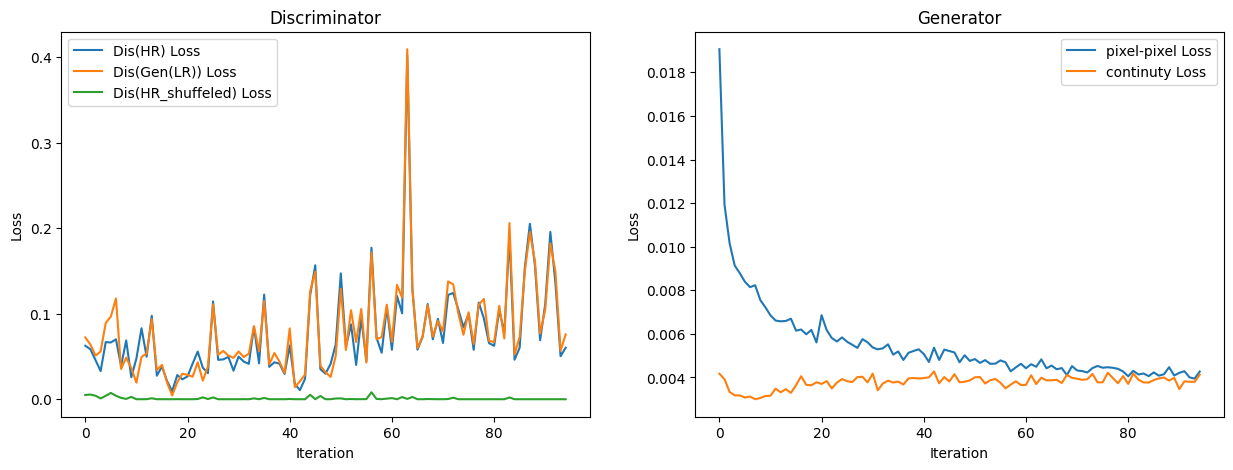

Epoch number:  96
0.011045862920582294      GAN loss:  0.19313010573387146      -3.2933006286621094      -2.213329315185547      -36.9991340637207
0.011648103594779968      GAN loss:  0.11067871749401093      -3.0653724670410156      6.645053863525391      -31.932527542114258
0.011882749386131763      GAN loss:  3.150953125441447e-05      -14.221449851989746      10.09373950958252      -39.229759216308594
0.01130501739680767      GAN loss:  0.023520490154623985      -13.840511322021484      5.78718376159668      -43.088138580322266
0.011763007380068302      GAN loss:  0.002787970006465912      -9.341981887817383      11.147380828857422      -39.380531311035156
0.011487661860883236      GAN loss:  0.05340851470828056      -3.811656951904297      10.818658828735352      -42.00262451171875
0.012254818342626095      GAN loss:  7.847313099773601e-05      -12.673843383789062      10.537309646606445      -37.32315444946289
0.01171564869582653      GAN loss:  8.593094207753893e-06      -15.631

In [ ]:
if __name__ == '__main__':
    main()